In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from matplotlib import cm

In [2]:
df = pd.read_csv("./3d.txt")
print(df.head)

<bound method NDFrame.head of       Unnamed: 0.1  Unnamed: 0    r1     r2       r3        v
0           127900      127900  2.31   8.71  6.40276  0.06406
1            82216       82216  1.71   5.01  3.30206  0.01431
2           440358      440358  6.71   7.71  1.00519  0.04829
3           302658      302658  4.81   3.61  1.20288  0.01148
4            53467       53467  1.31   4.71  3.40055  0.00454
...            ...         ...   ...    ...      ...      ...
4165        272588      272588  4.41   1.61  2.80080  0.01077
4166        475239      475239  7.21   5.61  1.60613  0.00609
4167         49329       49329  1.21   8.41  7.20092  0.00849
4168        100055      100055  1.91   9.51  7.60185  0.02840
4169         43643       43643  1.11  10.21  9.10068  0.02255

[4170 rows x 6 columns]>


In [3]:
X = df[["r1","r2","r3"]]
y = df[['v']]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [4]:
from sklearn import preprocessing

In [5]:
scaler = preprocessing.StandardScaler()
scaler_y = preprocessing.StandardScaler()
scaler.fit(X_train)
scaler_y.fit(y_train)
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()
y_train = scaler_y.transform(y_train)
y_test = scaler_y.transform(y_test)

In [6]:
dtype = torch.float

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.my_linear_net = nn.Sequential(
            # first layer
            nn.BatchNorm1d(num_features=3),
            nn.Linear(in_features=3,out_features=240),
            nn.BatchNorm1d(num_features=240),
            # second layer
            nn.Linear(in_features=240,out_features=120),
            nn.Sigmoid(),
            nn.BatchNorm1d(num_features=120),
            # third layer
            nn.Linear(in_features=120,out_features=30),
            nn.BatchNorm1d(num_features=30),
            # output layer
            nn.Linear(in_features=30,out_features=1),
        )

    def forward(self,x):
        x = torch.exp(1-x)
        r1 = x[:,0]
        r2 = x[:,1]
        r3 = x[:,2]
#         r1_ = r1+r2
#         r2_ = r1*r2
        x = torch.stack((r1,r2,r3),1)
        x = self.my_linear_net(x)
        return x

In [7]:
device = torch.device('cuda')

In [8]:
net = Net().to(device)

opt = torch.optim.SGD(net.parameters(),lr=0.65)
criterion = nn.SmoothL1Loss()

net.train()

Net(
  (my_linear_net): Sequential(
    (0): BatchNorm1d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=3, out_features=240, bias=True)
    (2): BatchNorm1d(240, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Linear(in_features=240, out_features=120, bias=True)
    (4): Sigmoid()
    (5): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Linear(in_features=120, out_features=30, bias=True)
    (7): BatchNorm1d(30, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Linear(in_features=30, out_features=1, bias=True)
  )
)

In [9]:
def fit(x,y):
    for i in range(30000):
        # 对x进行预测
        outputs = net(x) # net.forward(x)
        # 计算损失
        loss = criterion(outputs, y)
        # 每次迭代清空上一次的梯度
        opt.zero_grad()
        # 反向传播
        loss.backward()
        # 更新梯度
        opt.step()
        # print(loss.item())

In [10]:
X_train = torch.tensor(X_train).clone().detach().to(dtype).to(device)
y_train = torch.tensor(y_train).clone().detach().to(dtype).to(device)
X_test = torch.tensor(X_test).clone().detach().to(dtype).to(device)
y_test = torch.tensor(y_test).clone().detach().to(dtype).to(device)
fit(X_train,y_train)
net.eval()


from sklearn.metrics import mean_squared_error, r2_score
y_pred_train = net.forward(X_train).clone().detach().cpu().numpy()
y_pred = net.forward(X_test).clone().detach().cpu().numpy()
train_mse = np.sqrt(mean_squared_error(y_train.clone().detach().cpu().numpy(), y_pred_train))
rmse_MLR = np.sqrt(mean_squared_error(y_test.clone().detach().cpu().numpy(), y_pred))

r2 = r2_score(y_test.clone().detach().cpu().numpy(), y_pred)

print('R2 test = ', r2)
print('RSME train = ', train_mse)
print('RSME test = ', rmse_MLR)



R2 test =  0.9999130528770195
RSME train =  0.0080904495
RSME test =  0.009281996


In [11]:
out = []
for i in range(100):
    x = np.linspace(0.91,9.91,100)
    y = np.full(100,0.91+i*0.09)
    z = np.full(100,2.2)
    x = torch.tensor(x).to(dtype).to(device)
    y = torch.tensor(y).to(dtype).to(device)
    z = torch.tensor(z).to(dtype).to(device)
    xyz = torch.stack((x,y,z),1).to(dtype).to(device)
    o = net.forward(xyz).clone().detach().cpu().numpy()
    o = scaler_y.inverse_transform(o)
    out = np.concatenate((out,o),axis=None)

In [12]:
out = out.reshape(100,100)

In [13]:
x = np.linspace(0.91,9.91,100)
y = np.linspace(0.91,9.91,100)
X, Y = np.meshgrid(x, y)
out[out > 0.14] =0.14

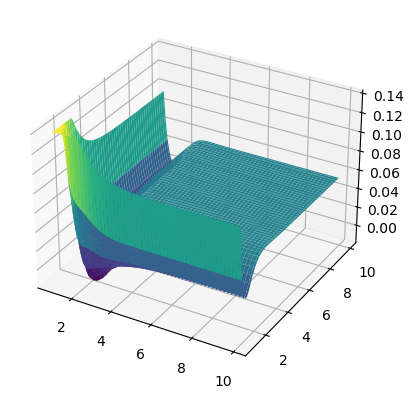

In [14]:
%matplotlib inline
axes = plt.axes(projection='3d')
axes.plot_surface(X, Y, out, cmap=cm.viridis)
# axes.set_zlim(0,0.15)

plt.show()